# 🥉 Bước 2: Bronze Layer - Ingestion Dữ liệu Thô

## Credit Card Fraud Detection - IEEE-CIS Dataset

**Mục tiêu:**
- Đọc dữ liệu CSV từ local
- Ghi vào MinIO dưới định dạng Apache Iceberg
- Thêm metadata columns: `_ingestion_time`, `_source_file`
- Giữ nguyên dữ liệu gốc (raw data)

## 1. Khởi tạo Spark Session với Iceberg Catalog

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp, lit, col
from datetime import datetime

# Khởi tạo Spark Session với cấu hình Iceberg REST Catalog
spark = SparkSession.builder \
    .appName("Bronze Layer - Fraud Detection") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.demo", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.demo.type", "rest") \
    .config("spark.sql.catalog.demo.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.demo.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.demo.warehouse", "s3://warehouse/") \
    .config("spark.sql.catalog.demo.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.demo.s3.path-style-access", "true") \
    .config("spark.sql.catalog.demo.s3.access-key-id", "admin") \
    .config("spark.sql.catalog.demo.s3.secret-access-key", "password123") \
    .config("spark.sql.defaultCatalog", "demo") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "admin") \
    .config("spark.hadoop.fs.s3a.secret.key", "password123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

print(f"✅ Spark version: {spark.version}")
print("✅ Spark Session đã khởi tạo thành công với Iceberg REST Catalog!")

✅ Spark version: 3.5.5
✅ Spark Session đã khởi tạo thành công với Iceberg REST Catalog!


26/02/02 07:12:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## 2. Tạo Namespace cho Bronze Layer

In [2]:
# Tạo namespace bronze trong catalog demo
spark.sql("CREATE NAMESPACE IF NOT EXISTS demo.bronze")

print("📁 Danh sách Namespaces trong Catalog:")
spark.sql("SHOW NAMESPACES IN demo").show()

📁 Danh sách Namespaces trong Catalog:
+-------------+
|    namespace|
+-------------+
|       bronze|
|  bronze_gold|
|bronze_silver|
|      default|
+-------------+



## 3. Đọc và Ingest Transaction Data (Dữ liệu giao dịch)

In [3]:
# Đọc dữ liệu transaction từ CSV
df_transaction = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/home/spark/notebooks/data/train_transaction.csv")

print(f"📊 Transaction Data:")
print(f"   - Số dòng: {df_transaction.count():,}")
print(f"   - Số cột: {len(df_transaction.columns)}")
print(f"\n📋 Các cột chính:")
print(df_transaction.columns[:15])  # Hiển thị 15 cột đầu tiên

📊 Transaction Data:


   - Số dòng: 590,540
   - Số cột: 394

📋 Các cột chính:
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2']


/tmp/ipykernel_506/3299455861.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


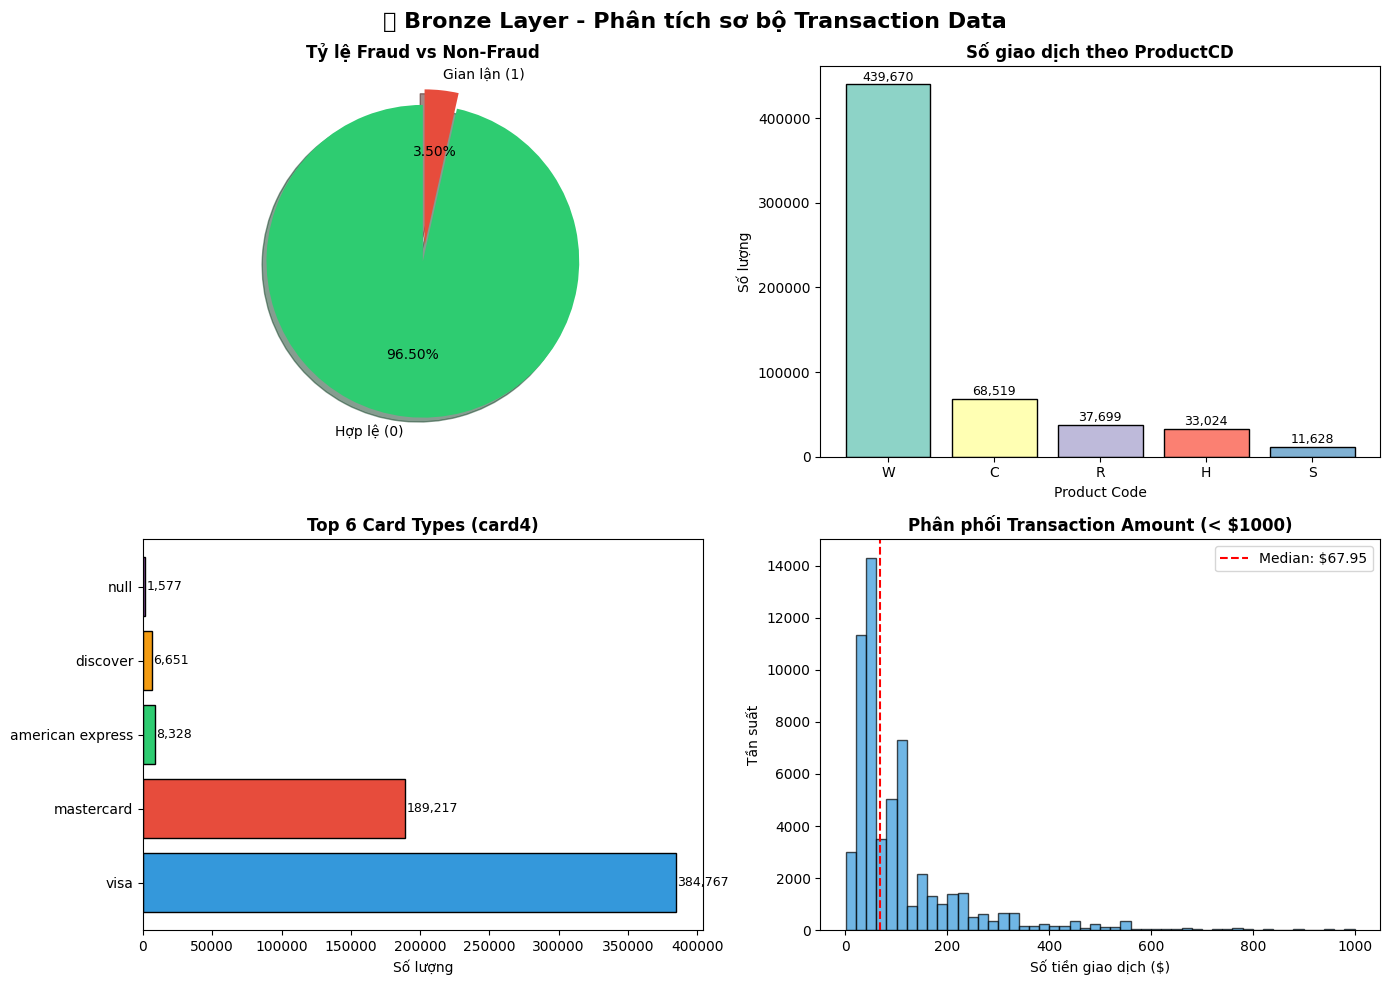

📊 Nhận xét ban đầu:
   - Tỷ lệ gian lận: 3.50%
   - Product phổ biến nhất: W (439,670 giao dịch)
   - Card type phổ biến nhất: visa (384,767 giao dịch)


In [4]:
# 📊 VISUALIZATION: Phân tích sơ bộ Transaction Data
import matplotlib.pyplot as plt

# Tạo figure với nhiều subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 Bronze Layer - Phân tích sơ bộ Transaction Data', fontsize=16, fontweight='bold')

# 1. Phân phối Fraud vs Non-Fraud
fraud_counts = df_transaction.groupBy("isFraud").count().collect()
fraud_data = {row['isFraud']: row['count'] for row in fraud_counts}
labels = ['Hợp lệ (0)', 'Gian lận (1)']
sizes = [fraud_data.get(0, 0), fraud_data.get(1, 0)]
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)

axes[0, 0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%',
               shadow=True, startangle=90)
axes[0, 0].set_title('Tỷ lệ Fraud vs Non-Fraud', fontsize=12, fontweight='bold')

# 2. Phân phối theo ProductCD
product_counts = df_transaction.groupBy("ProductCD").count().orderBy("count", ascending=False).collect()
products = [row['ProductCD'] for row in product_counts]
counts = [row['count'] for row in product_counts]
colors_bar = plt.cm.Set3(range(len(products)))

bars = axes[0, 1].bar(products, counts, color=colors_bar, edgecolor='black')
axes[0, 1].set_title('Số giao dịch theo ProductCD', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Product Code')
axes[0, 1].set_ylabel('Số lượng')
for bar, count in zip(bars, counts):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                    f'{count:,}', ha='center', va='bottom', fontsize=9)

# 3. Phân phối theo Card Type (card4)
card_counts = df_transaction.groupBy("card4").count().orderBy("count", ascending=False).collect()
cards = [str(row['card4']) if row['card4'] else 'null' for row in card_counts[:6]]
card_cnts = [row['count'] for row in card_counts[:6]]
colors_card = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#95a5a6']

axes[1, 0].barh(cards, card_cnts, color=colors_card, edgecolor='black')
axes[1, 0].set_title('Top 6 Card Types (card4)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Số lượng')
for i, (card, cnt) in enumerate(zip(cards, card_cnts)):
    axes[1, 0].text(cnt + 1000, i, f'{cnt:,}', va='center', fontsize=9)

# 4. Phân phối TransactionAmt (histogram)
amt_sample = df_transaction.select("TransactionAmt").filter(col("TransactionAmt") < 1000).sample(0.1).toPandas()
axes[1, 1].hist(amt_sample['TransactionAmt'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Phân phối Transaction Amount (< $1000)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Số tiền giao dịch ($)')
axes[1, 1].set_ylabel('Tần suất')
axes[1, 1].axvline(x=amt_sample['TransactionAmt'].median(), color='red', linestyle='--', 
                   label=f'Median: ${amt_sample["TransactionAmt"].median():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("📊 Nhận xét ban đầu:")
print(f"   - Tỷ lệ gian lận: {sizes[1]/(sizes[0]+sizes[1])*100:.2f}%")
print(f"   - Product phổ biến nhất: {products[0]} ({counts[0]:,} giao dịch)")
print(f"   - Card type phổ biến nhất: {cards[0]} ({card_cnts[0]:,} giao dịch)")

In [5]:
# Thêm metadata columns theo yêu cầu Bronze Layer
df_transaction_bronze = df_transaction \
    .withColumn("_ingestion_time", current_timestamp()) \
    .withColumn("_source_file", lit("train_transaction.csv"))

# Xem schema với metadata
print("📋 Schema của Bronze Transaction (có thêm metadata):")
df_transaction_bronze.printSchema()

📋 Schema của Bronze Transaction (có thêm metadata):
root
 |-- TransactionID: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- TransactionDT: integer (nullable = true)
 |-- TransactionAmt: double (nullable = true)
 |-- ProductCD: string (nullable = true)
 |-- card1: integer (nullable = true)
 |-- card2: double (nullable = true)
 |-- card3: double (nullable = true)
 |-- card4: string (nullable = true)
 |-- card5: double (nullable = true)
 |-- card6: string (nullable = true)
 |-- addr1: double (nullable = true)
 |-- addr2: double (nullable = true)
 |-- dist1: double (nullable = true)
 |-- dist2: double (nullable = true)
 |-- P_emaildomain: string (nullable = true)
 |-- R_emaildomain: string (nullable = true)
 |-- C1: double (nullable = true)
 |-- C2: double (nullable = true)
 |-- C3: double (nullable = true)
 |-- C4: double (nullable = true)
 |-- C5: double (nullable = true)
 |-- C6: double (nullable = true)
 |-- C7: double (nullable = true)
 |-- C8: double (nullable

In [6]:
# Ghi vào Iceberg Table trên MinIO
df_transaction_bronze.writeTo("demo.bronze.transactions") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.bronze.transactions trên MinIO/Iceberg!")

26/02/02 07:14:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


✅ Đã tạo bảng demo.bronze.transactions trên MinIO/Iceberg!


## 4. Đọc và Ingest Identity Data (Dữ liệu định danh)

In [7]:
# Đọc dữ liệu identity từ CSV
df_identity = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/home/spark/notebooks/data/train_identity.csv")

print(f"📊 Identity Data:")
print(f"   - Số dòng: {df_identity.count():,}")
print(f"   - Số cột: {len(df_identity.columns)}")
print(f"\n📋 Các cột:")
print(df_identity.columns)

📊 Identity Data:
   - Số dòng: 144,233
   - Số cột: 41

📋 Các cột:
['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


/tmp/ipykernel_506/3167187596.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


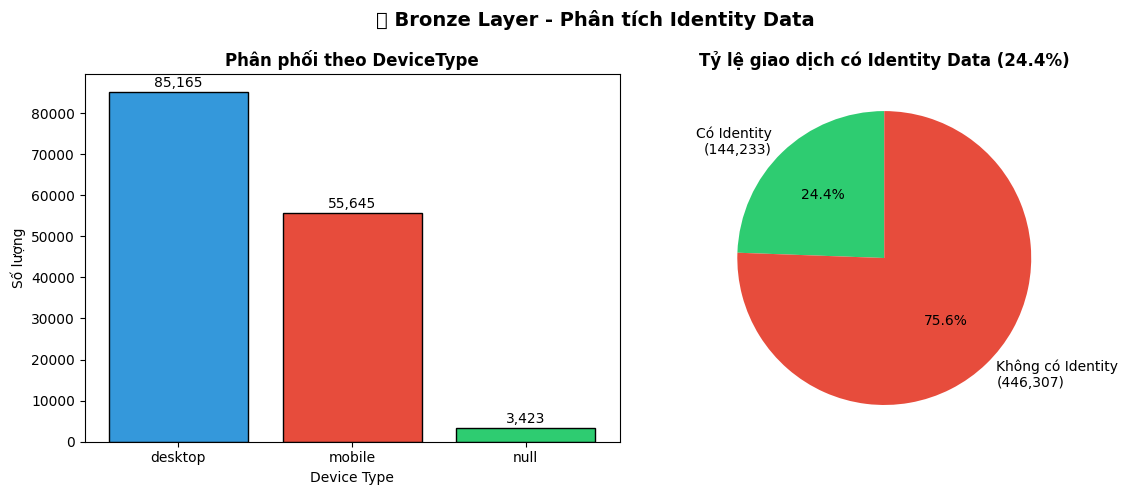

📊 Nhận xét Identity Data:
   - Tổng records: 144,233
   - Tỷ lệ có identity: 24.4%
   - Device phổ biến nhất: desktop (85,165 records)


In [8]:
# 📊 VISUALIZATION: Phân tích Identity Data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('📊 Bronze Layer - Phân tích Identity Data', fontsize=14, fontweight='bold')

# 1. Phân phối theo DeviceType
device_counts = df_identity.groupBy("DeviceType").count().orderBy("count", ascending=False).collect()
devices = [str(row['DeviceType']) if row['DeviceType'] else 'null' for row in device_counts]
dev_cnts = [row['count'] for row in device_counts]
colors_dev = ['#3498db', '#e74c3c', '#2ecc71']

axes[0].bar(devices, dev_cnts, color=colors_dev, edgecolor='black')
axes[0].set_title('Phân phối theo DeviceType', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Device Type')
axes[0].set_ylabel('Số lượng')
for i, (dev, cnt) in enumerate(zip(devices, dev_cnts)):
    axes[0].text(i, cnt + 500, f'{cnt:,}', ha='center', va='bottom', fontsize=10)

# 2. Tỷ lệ Identity có trong Transactions
identity_count = df_identity.count()
tx_count = df_transaction.count()
identity_pct = (identity_count / tx_count) * 100

sizes = [identity_count, tx_count - identity_count]
labels = [f'Có Identity\n({identity_count:,})', f'Không có Identity\n({tx_count - identity_count:,})']
colors = ['#2ecc71', '#e74c3c']

axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title(f'Tỷ lệ giao dịch có Identity Data ({identity_pct:.1f}%)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Nhận xét Identity Data:")
print(f"   - Tổng records: {identity_count:,}")
print(f"   - Tỷ lệ có identity: {identity_pct:.1f}%")
print(f"   - Device phổ biến nhất: {devices[0]} ({dev_cnts[0]:,} records)")

In [9]:
# Thêm metadata columns
df_identity_bronze = df_identity \
    .withColumn("_ingestion_time", current_timestamp()) \
    .withColumn("_source_file", lit("train_identity.csv"))

# Ghi vào Iceberg Table
df_identity_bronze.writeTo("demo.bronze.identity") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.bronze.identity trên MinIO/Iceberg!")

✅ Đã tạo bảng demo.bronze.identity trên MinIO/Iceberg!


## 5. Xác minh Bronze Layer

In [10]:
# Kiểm tra các bảng đã tạo trong Bronze Layer
print("📁 Danh sách bảng trong Bronze Layer:")
spark.sql("SHOW TABLES IN demo.bronze").show()

# Thống kê số lượng records
print("\n📊 Thống kê Bronze Tables:")
tx_count = spark.sql("SELECT COUNT(*) as cnt FROM demo.bronze.transactions").collect()[0][0]
id_count = spark.sql("SELECT COUNT(*) as cnt FROM demo.bronze.identity").collect()[0][0]

print(f"   - Transactions: {tx_count:,} records")
print(f"   - Identity: {id_count:,} records")

📁 Danh sách bảng trong Bronze Layer:
+---------+------------+-----------+
|namespace|   tableName|isTemporary|
+---------+------------+-----------+
|   bronze|    identity|      false|
|   bronze|transactions|      false|
+---------+------------+-----------+


📊 Thống kê Bronze Tables:
   - Transactions: 590,540 records
   - Identity: 144,233 records


In [11]:
# Xem mẫu dữ liệu Transaction (Bronze)
print("📋 Sample Transactions (Bronze):")
spark.sql("""
    SELECT TransactionID, isFraud, TransactionAmt, ProductCD, card4, card6, 
           _ingestion_time, _source_file
    FROM demo.bronze.transactions 
    LIMIT 5
""").show(truncate=False)

📋 Sample Transactions (Bronze):


+-------------+-------+--------------+---------+----------+------+--------------------------+---------------------+
|TransactionID|isFraud|TransactionAmt|ProductCD|card4     |card6 |_ingestion_time           |_source_file         |
+-------------+-------+--------------+---------+----------+------+--------------------------+---------------------+
|2987000      |0      |68.5          |W        |discover  |credit|2026-02-02 07:14:30.813735|train_transaction.csv|
|2987001      |0      |29.0          |W        |mastercard|credit|2026-02-02 07:14:30.813735|train_transaction.csv|
|2987002      |0      |59.0          |W        |visa      |debit |2026-02-02 07:14:30.813735|train_transaction.csv|
|2987003      |0      |50.0          |W        |mastercard|debit |2026-02-02 07:14:30.813735|train_transaction.csv|
|2987004      |0      |50.0          |H        |mastercard|credit|2026-02-02 07:14:30.813735|train_transaction.csv|
+-------------+-------+--------------+---------+----------+------+------

In [12]:
# Kiểm tra Iceberg Table History - quan trọng cho Time Travel sau này
print("📜 Iceberg Table History (Transactions):")
spark.sql("SELECT * FROM demo.bronze.transactions.history").show(truncate=False)

print("\n📜 Iceberg Table Snapshots:")
spark.sql("SELECT * FROM demo.bronze.transactions.snapshots").show(truncate=False)

📜 Iceberg Table History (Transactions):
+-----------------------+-------------------+---------+-------------------+
|made_current_at        |snapshot_id        |parent_id|is_current_ancestor|
+-----------------------+-------------------+---------+-------------------+
|2026-02-02 07:16:06.043|4727601644467742827|NULL     |true               |
+-----------------------+-------------------+---------+-------------------+


📜 Iceberg Table Snapshots:
+-----------------------+-------------------+---------+---------+----------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_506/3368644845.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_506/3368644845.py:33: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_506/3368644845.py:33: UserWarning: Glyph 7845 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND ACUTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_506/3368644845.py:33: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7845 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND ACUTE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.pri

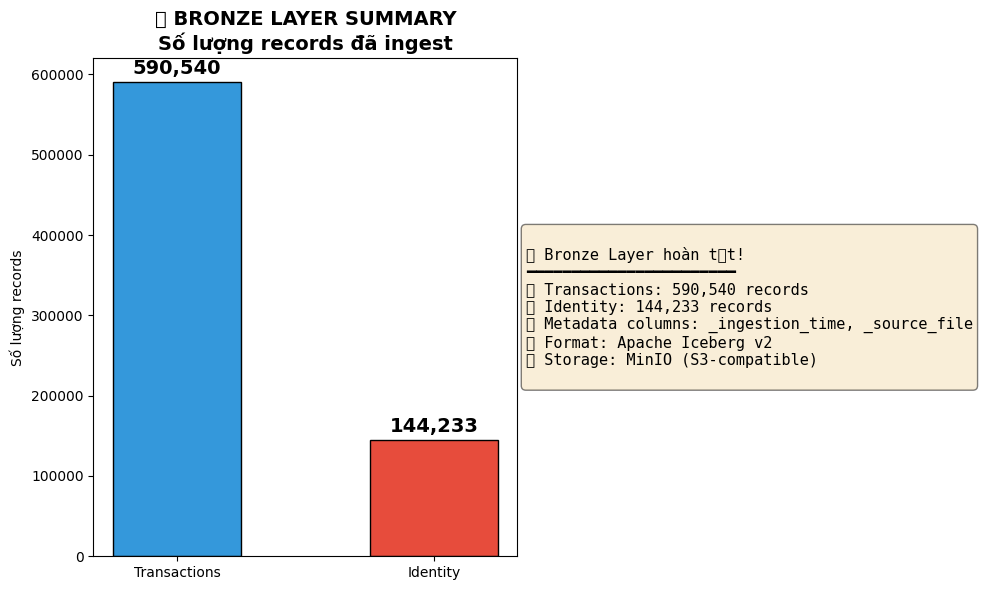

In [13]:
# 📊 VISUALIZATION: Tổng kết Bronze Layer
fig, ax = plt.subplots(figsize=(10, 6))

# Tạo summary chart
tables = ['Transactions', 'Identity']
counts = [tx_count, id_count]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(tables, counts, color=colors, edgecolor='black', width=0.5)

ax.set_title('📊 BRONZE LAYER SUMMARY\nSố lượng records đã ingest', fontsize=14, fontweight='bold')
ax.set_ylabel('Số lượng records')

# Thêm labels
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
            f'{count:,}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Thêm thông tin metadata
info_text = f"""
📁 Bronze Layer hoàn tất!
━━━━━━━━━━━━━━━━━━━━━━━
✅ Transactions: {tx_count:,} records
✅ Identity: {id_count:,} records
✅ Metadata columns: _ingestion_time, _source_file
✅ Format: Apache Iceberg v2
✅ Storage: MinIO (S3-compatible)
"""
ax.text(1.02, 0.5, info_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## ✅ Hoàn thành Bronze Layer

**Kết quả:**
- ✅ Đã ingest `train_transaction.csv` → `demo.bronze.transactions`
- ✅ Đã ingest `train_identity.csv` → `demo.bronze.identity`
- ✅ Thêm metadata columns: `_ingestion_time`, `_source_file`
- ✅ Dữ liệu được lưu trên MinIO dưới định dạng Apache Iceberg

**Tiếp theo:** Chạy notebook `02_silver_layer.ipynb` để làm sạch dữ liệu.